# 12 Oct 23 - Activity: Method of Relaxation in 2D

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def set_boundary(phi, boundary, V):
    """
    Set boundary conditions.

    Parameters:
        phi: 2D numpy array
            The grid to which boundary conditions should be applied.
        boundary: str
            Specify which boundary to set. Options: 'top', 'bottom', 'left', 'right'.
        V: float or 1D numpy array
            The potential value(s) to set on the boundary.
    """
    if boundary == 'top':
        phi[0, :] = V
    elif boundary == 'bottom':
        phi[-1, :] = V
    elif boundary == 'left':
        phi[:, 0] = V
    elif boundary == 'right':
        phi[:, -1] = V
    else:
        raise ValueError("Invalid boundary. Choose from 'top', 'bottom', 'left', 'right'.")


In [16]:
def relax(phi, N, tolerance, max_iterations=10000, store_frequency=1000):
    
    iterations = 0
    delta = 1.0
    
    stored_phi = []
    stored_deltas = []
    
    while delta > tolerance and iterations < max_iterations:
        # Store the old phi values to calculate delta later
        phi_old = phi.copy()
        
        for i in range(1, N-1):
            for j in range(1, N-1):
                phi[i, j] = 0.25 * (phi_old[i+1, j] + phi_old[i-1, j] + phi_old[i, j+1] + phi_old[i, j-1])
        
        # Calculate delta: max difference between new and old phi values
        delta = np.max(np.abs(phi - phi_old))
        
        iterations += 1
        
        if iterations % store_frequency == 0:
            stored_phi.append(phi.copy())
            stored_deltas.append(delta)
            print(f"Iteration: {iterations}, Delta: {delta}")
    
    return stored_phi, stored_deltas, iterations


In [17]:

def plot_potential(phi, L):
    """
    Visualize the potential.
    """
    plt.imshow(phi, extent=[0, L, 0, L], origin='lower')
    plt.title("2D Electric Potential")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label="Potential ($\Phi$)")
    plt.show()


In [18]:
def plot_phi_deltas(stored_phi, stored_deltas, store_frequency=100):
    """
    Plots stored potentials and delta values.
    
    stored_phi: list of ndarray, stored phi grids.
    stored_deltas: list of float, stored delta values corresponding to stored_phi grids.
    store_frequency: int, the frequency at which the data was stored.
    """
    num_stored = len(stored_phi)
    
    fig, axs = plt.subplots(num_stored, 2, figsize=(12, 4*num_stored))
    
    for i in range(num_stored):
        # Plot potentials
        im = axs[i, 0].imshow(stored_phi[i], extent=[0, 1, 0, 1], origin='lower', aspect='auto')
        axs[i, 0].set_title(f"Potential at Iteration {(i + 1) * store_frequency}")
        fig.colorbar(im, ax=axs[i, 0], label="Potential ($\Phi$)")
        
        # Plot deltas
        axs[i, 1].plot(stored_deltas[:i+1], marker='o')
        axs[i, 1].set_title(f"Convergence ($\Delta$) up to Iteration {(i + 1) * store_frequency}")
        axs[i, 1].set_xlabel("Stored Iteration Index")
        axs[i, 1].set_ylabel("$\Delta$")
        axs[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


In [19]:

# Example Usage
L = 1.0
h = 0.01
tolerance = 1e-5
N = int(L/h)

phi = np.zeros((N+1, N+1))

# Set varying potential on top boundary
x = np.linspace(0, L, N+1)
V_top = 10 * np.sin(2 * np.pi * x)
set_boundary(phi, 'top', V_top)

# Set constant potential on other boundaries
set_boundary(phi, 'bottom', 0)
set_boundary(phi, 'left', 5)
set_boundary(phi, 'right', 5)

# Relaxation
stored_phi, stored_deltas, iterations = relax(phi, N, tolerance)
print(f"Converged in {iterations} iterations.")


Iteration: 1000, Delta: 0.0017978266833984513
Iteration: 2000, Delta: 0.0005961642170166925
Iteration: 3000, Delta: 0.0002723263734800696
Iteration: 4000, Delta: 0.00014617124686600036
Iteration: 5000, Delta: 8.507752133146695e-05
Iteration: 6000, Delta: 5.0934270772406975e-05
Iteration: 7000, Delta: 3.071462110559864e-05
Iteration: 8000, Delta: 1.8554939076320665e-05
Iteration: 9000, Delta: 1.1212328081766643e-05
Converged in 9228 iterations.


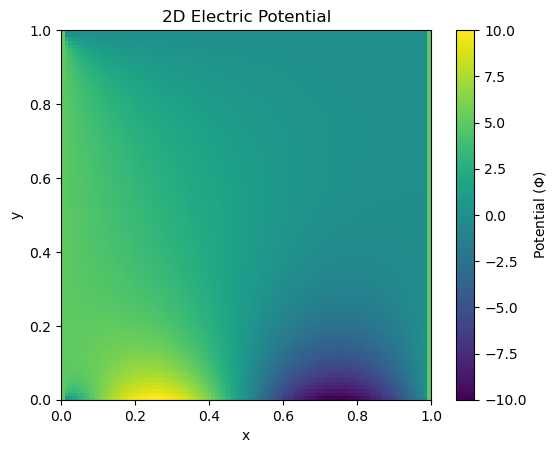

In [12]:

# Visualization
plot_potential(phi, L)


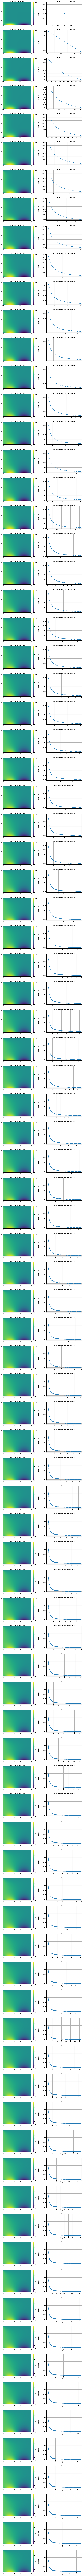

In [15]:

plot_phi_deltas(stored_phi, stored_deltas)

Now we can "upgrade" to the Poisson equation:

$$\nabla^2 \phi = -\frac{\rho}{\epsilon_0}$$

Where $\rho$ is a **charge density**.

Substituting our 2nd partial derivative equations gives us:

$$
\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2}  = \frac{\phi(x+h,y) + \phi(x-h,y) - 2\phi(x,y) + \phi(x,y+h) + \phi(x,y-h) - 2\phi(x,y)}{h^2} = -\frac{\rho}{\epsilon_0}
$$

Which in turn gives us the update equation:

$$
\phi_{k+1}(x,y) = \frac{1}{4}\left[\phi_{k}(x+h,y) + \phi_{k}(x-h,y) + \phi_{k}(x,y+h) + \phi_{k}(x,y-h) \right] + \frac{h^2}{4\epsilon_0} \rho(x,y)
$$

With a couple minor edits to our previous code, we can implement this (warning: this takes a long time to converge).

In [7]:
# constants and parameters
L = 1
h = 0.01
V = 1
N = int(L/0.01)
tol = 1e-5
epsilon0 = 8.854e-12

# setup phi, phiprime arrays
phi = np.zeros((N+1,N+1))
phiprime = np.copy(phi) # to play the part of phi (k+1)

def rho(i,j):
    x = i * h
    y = j * h
    if x >= 0.6 and x <= 0.8 and y >= 0.2 and y <= 0.4:
        return 0.01
    elif x >= 0.2 and x <= 0.4 and y >= 0.6 and y <= 0.8:
        return -0.01
    else:
        return 0.

k = 0 # track number of iterations
delta = 1.0 # initial delta

while delta > tol: # run until converged

    for i in range(N+1):
        for j in range(N+1):
            if i == 0 or i == N or j == 0 or  j == N: # don't update boundary
                phiprime[i,j] = phi[i,j]
            else:
                # relaxation update equation
                phiprime[i,j] = 0.25 * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1]) + h**2 / (4 * epsilon0) * rho(i,j)

    # find max difference for delta
    delta = np.abs(phi-phiprime).max()

    # swap arrays to keep iterating
    phi,phiprime = phiprime,phi 
    
    # track iterations
    k += 1
    if k%500 == 0 or k ==1:
        print("iter:",k,"delta:",delta)         
    delta = np.abs(phi-phiprime).max()

print(k)
plt.imshow(phi)
plt.show()

iter: 1 delta: 28235.825615541005
iter: 500 delta: 6832.1411354132
iter: 1000 delta: 3251.0140515118837


KeyboardInterrupt: 